## Masters of the Great Web and Cyberpunks. ERC721 Analysis

In [1]:
import pandas as pd

from config import ETHERSCAN_NFT_CSV_NAME, PROJECT_ID, INITIAL_TS, SNAPSHOT_TS, \
    ERC721_ANALYSIS_DATASET_NAME, ERC721_AMOUNT_TABLE_NAME, ERC721_ANALYSIS_DISTRIBUTION_TABLE_NAME, \
    ERC721_NFT_TOKEN_TABLE_NAME, ERC721_TOKEN_TABLE_NAME, MASTERS_AUDIENCE, \
    CRYPTOPUNKS_AUDIENCE
from src.utils_bigquery import drop_table, create_table, get_df, create_table_from_df
from src.utils_charts import grade_boundaries_analysis
from src.extractors import extract_nft_tokens

EXTRACT_NFT = False
DROP_TABLES = True
CREATE_TABLES = True

### Distribution Rule. Masters of the Great Web

<table style="text-align: left">
    <thead style="text-align: center">
        <tr>
            <th rowspan=2></th>
            <th colspan=3>Grade</th>
        </tr>
        <tr>
            <th>1</th>
            <th>2</th>
            <th>3</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td style="text-align: left"> Amount of ERC721 tokens </td>
            <td style="text-align: center"> > 0 NFT </td>
            <td style="text-align: center"> > 7 NFT </td>
            <td style="text-align: center"> > 186 NFT </td>
        </tr>
        <tr>
            <td style="text-align: left"> Owners of the Selected ERC721 tokens </td>
            <td style="text-align: center"> - </td>
            <td style="text-align: center"> ENS </td>
            <td style="text-align: center"> Gitcoin Kudos or LAND </td>
        </tr>
        <tr>
            <td style="text-align: left"> Fee spending to contracts<sup>1</sup>, by contract creators, ETH </td>
            <td style="text-align: center"> > 0 ETH </td>
            <td style="text-align: center"> > 0.005 ETH </td>
            <td style="text-align: center"> > 0.7557 ETH </td>
        </tr>
    </tbody>
</table>

<sup>1</sup> including contracts created by factories only


### Distribution Rule. Cyberpunks

<table style="text-align: left">
    <thead style="text-align: center">
        <tr>
            <th rowspan=2></th>
            <th colspan=3>Grade</th>
        </tr>
        <tr>
            <th>1</th>
            <th>2</th>
            <th>3</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td style="text-align: left"> Owners of the Selected ERC721 tokens </td>
            <td style="text-align: center"> - </td>
            <td style="text-align: center"> - </td>
            <td style="text-align: center"> Unicorns, DRAGON or Cryptopunks </td>
        </tr>
    </tbody>
</table>

In [2]:
min_number_of_tokens = 0
boundary_erc721_amount = [0, 7, 186]

erc721_tokens_manual_grade_2_dict = {
    'ENS': '0x57f1887a8bf19b14fc0df6fd9b2acc9af147ea85'}
erc721_tokens_manual_grade_3_dict = {
    'Gitcoin Kudos': '0x2aea4add166ebf38b63d09a75de1a7b94aa24163',
    'LAND': '0xf87e31492faf9a91b02ee0deaad50d51d56d5d4d'}
erc721_tokens_manual_cryptopunks_dict = {
    'Unicorns': '0x89205a3a3b2a69de6dbf7f01ed13b2108b2c43e7',
    'DRAGON': '0x960f401aed58668ef476ef02b2a2d43b83c261d8',
    'Cryptopunks': '0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb'}

### Set Token Data

In [3]:
# Get NFT list from Etherscan
if EXTRACT_NFT:
    extract_nft_tokens()

nft_tokens_df = pd.read_csv(ETHERSCAN_NFT_CSV_NAME, index_col=0)

erc721_tokens_manual_grade_2_tuple_str = str(tuple(erc721_tokens_manual_grade_2_dict.values())).replace(',)', ')')
erc721_tokens_manual_grade_3_tuple_str = str(tuple(erc721_tokens_manual_grade_3_dict.values())).replace(',)', ')')
erc721_tokens_manual_cryptopunks_tuple_str = str(tuple(erc721_tokens_manual_cryptopunks_dict.values())).replace(',)', ')')

### Create NFT Token Table

In [4]:
if CREATE_TABLES:
    create_table_from_df(source_df=nft_tokens_df,
                         table_name=ERC721_NFT_TOKEN_TABLE_NAME,
                         dataset_name=ERC721_ANALYSIS_DATASET_NAME,
                         drop_existing_table=DROP_TABLES)

Table erc721_analysis:nft_tokens has been deleted.


### Create Aggregated ERC721 Token Table

In [5]:
query_1 = f'''
    WITH etherscan_nft_tokens AS (
        SELECT
            token_name AS name,
            token_address AS address,
            description,
            'etherscan' AS source
        FROM `{PROJECT_ID}.{ERC721_ANALYSIS_DATASET_NAME}.{ERC721_NFT_TOKEN_TABLE_NAME}`),
    erc721_manual_tokens AS (
        SELECT
            token.name AS name,
            token.address AS address,
            'manual' AS source
        FROM UNNEST(
            [{''.join(f"STRUCT('{k}' AS name,'{v}' AS address), " for k,v in {**erc721_tokens_manual_grade_2_dict, **erc721_tokens_manual_grade_3_dict}.items())[:-2]}]
            ) as token),
    erc721_ethereum_etl_tokens AS (
        SELECT
            address,
            'ethereum_etl' AS source
        FROM `bigquery-public-data.crypto_ethereum.contracts`
        WHERE is_erc721=True)

    SELECT
        address,
        symbol,
        COALESCE(token_names.name, etherscan_and_manual.name) as name,
        CASE
            WHEN ethereum_etl.source is null THEN etherscan_and_manual.source
            WHEN etherscan_and_manual.source is null THEN [ethereum_etl.source]
            ELSE array_concat(etherscan_and_manual.source, [ethereum_etl.source])
        END as source
    FROM (
        SELECT
            address,
            COALESCE(etherscan.name, manual.name) AS name,
            IF(COALESCE(etherscan.source, manual.source) = COALESCE(manual.source, etherscan.source),
               [COALESCE(etherscan.source, manual.source)],
               [COALESCE(etherscan.source, manual.source), COALESCE(manual.source, etherscan.source)]) AS source
        FROM etherscan_nft_tokens AS etherscan
        FULL OUTER JOIN erc721_manual_tokens as manual
        USING (address)
        ) as etherscan_and_manual
    FULL OUTER JOIN erc721_ethereum_etl_tokens as ethereum_etl
    USING (address)
    LEFT JOIN (
        SELECT
            address,
            ANY_VALUE(symbol) as symbol,
            ANY_VALUE(name) as name
        FROM `bigquery-public-data.crypto_ethereum.tokens`
        GROUP BY address) as token_names
    USING (address)
'''

if DROP_TABLES:
    drop_table(table_name=ERC721_TOKEN_TABLE_NAME,
               dataset_name=ERC721_ANALYSIS_DATASET_NAME)

if CREATE_TABLES:
    create_table(query=query_1,
                 table_name=ERC721_TOKEN_TABLE_NAME,
                 dataset_name=ERC721_ANALYSIS_DATASET_NAME)

Table erc721_analysis:erc721_tokens has been deleted.
Table erc721_analysis:erc721_tokens has been created and filled 12118 rows.


### Get Balances

In [6]:
query_2 = f'''
    WITH erc721_transfers as (
      SELECT
          token_address,
          from_address,
          to_address,
          [from_address, to_address] as addresses
      FROM `bigquery-public-data.crypto_ethereum.token_transfers`
      WHERE block_timestamp >= '{INITIAL_TS}'
        AND block_timestamp <= '{SNAPSHOT_TS}'
        AND token_address IN (
                SELECT address
                FROM `{PROJECT_ID}.{ERC721_ANALYSIS_DATASET_NAME}.{ERC721_TOKEN_TABLE_NAME}`
                )
      )
    SELECT
      token_address,
      address,
      sum(value) as amount
    FROM (
      SELECT
          token_address,
          address,
          if(address=from_address, -1, 1) as value
      FROM erc721_transfers
      CROSS JOIN UNNEST(erc721_transfers.addresses) AS address
      )
    WHERE address != '0x0000000000000000000000000000000000000000'
    GROUP BY token_address, address
'''

if DROP_TABLES:
    drop_table(table_name=ERC721_AMOUNT_TABLE_NAME,
               dataset_name=ERC721_ANALYSIS_DATASET_NAME)

if CREATE_TABLES:
    create_table(query=query_2,
                 table_name=ERC721_AMOUNT_TABLE_NAME,
                 dataset_name=ERC721_ANALYSIS_DATASET_NAME)

Table erc721_analysis:erc721_amounts has been deleted.
Table erc721_analysis:erc721_amounts has been created and filled 1303792 rows.


### Create Distribution Table for ERC721 Tokens

In [4]:
query_3 = f'''
    WITH erc721_amount AS (
        SELECT
            address,
            count(distinct token_address) as number_of_tokens,
            ARRAY_AGG(DISTINCT token_address) as token_list,
            sum(amount) as sum_amount
        FROM `{PROJECT_ID}.{ERC721_ANALYSIS_DATASET_NAME}.{ERC721_AMOUNT_TABLE_NAME}`
        WHERE amount > 0
        GROUP BY address)
    SELECT
        '{MASTERS_AUDIENCE}' as audience,
        CASE
            WHEN (SELECT COUNT(1) FROM UNNEST(token_list) el WHERE el IN {erc721_tokens_manual_grade_3_tuple_str}) > 0 THEN 'Owners of the Selected ERC721 tokens'
            WHEN (SELECT COUNT(1) FROM UNNEST(token_list) el WHERE el IN {erc721_tokens_manual_grade_2_tuple_str}) > 0 AND sum_amount <= {boundary_erc721_amount[2]} THEN 'Owners of the Selected ERC721 tokens'
            ELSE 'Owners of ERC721 tokens'
        END
        AS subtype,
        address,
        CASE
            WHEN sum_amount > {boundary_erc721_amount[2]} OR (SELECT COUNT(1) FROM UNNEST(token_list) el WHERE el IN {erc721_tokens_manual_grade_3_tuple_str}) > 0 THEN 3
            WHEN sum_amount > {boundary_erc721_amount[1]} OR (SELECT COUNT(1) FROM UNNEST(token_list) el WHERE el IN {erc721_tokens_manual_grade_2_tuple_str}) > 0 THEN 2
            WHEN sum_amount > {boundary_erc721_amount[0]} THEN 1
            ELSE null
        END
        AS grade,
        sum_amount,
        number_of_tokens
    FROM erc721_amount
    WHERE number_of_tokens > {min_number_of_tokens}

    UNION ALL

    SELECT
        '{CRYPTOPUNKS_AUDIENCE}' as audience,
        'Owners of the Selected ERC721 tokens' as subtype,
        address,
        3 AS grade,
        sum_amount,
        number_of_tokens
    FROM erc721_amount
    WHERE (SELECT COUNT(1) FROM UNNEST(token_list) el WHERE el IN {erc721_tokens_manual_cryptopunks_tuple_str}) > 0
'''

if DROP_TABLES:
    drop_table(table_name=ERC721_ANALYSIS_DISTRIBUTION_TABLE_NAME,
               dataset_name=ERC721_ANALYSIS_DATASET_NAME)

if CREATE_TABLES:
    create_table(query=query_3,
                 table_name=ERC721_ANALYSIS_DISTRIBUTION_TABLE_NAME,
                 dataset_name=ERC721_ANALYSIS_DATASET_NAME)


Table erc721_analysis:erc721_analysis_distribution has been deleted.
Table erc721_analysis:erc721_analysis_distribution has been created and filled 792072 rows.


### Create Distribution Table for Spending Fee Analysis
Distribution has been calculated in the [Extraordinary Hackers and Masters of the Great Web. Gas Analysis](extraordinary_hackers_and_masters__gas_analysis.ipynb) Jupyter notebook.

### Analysis of Grade Boundaries. Amount of ERC721 tokens

In [8]:
query_4 = f'''
    WITH amount_agg AS (
        SELECT
            address,
            count(distinct token_address) as number_of_tokens,
            sum(amount) as sum_amount
        FROM `{PROJECT_ID}.{ERC721_ANALYSIS_DATASET_NAME}.{ERC721_AMOUNT_TABLE_NAME}`
        WHERE amount > 0
        GROUP BY address
    )
    SELECT
        sum_amount,
        count(address) as number_of_addresses
    FROM amount_agg
    GROUP BY sum_amount
'''

address_agg_by_sum_amount_of_tokens_df = get_df(query_4)

Suggestion of Rules: 



Grade,Rule,Addresses,Percentage of Addresses
1,0.0 < Amount of ERC721 tokens <= 7.0,702297,88.7
2,7.0 < Amount of ERC721 tokens <= 186.0,81367,10.3
3,186.0 < Amount of ERC721 tokens,7907,1.0


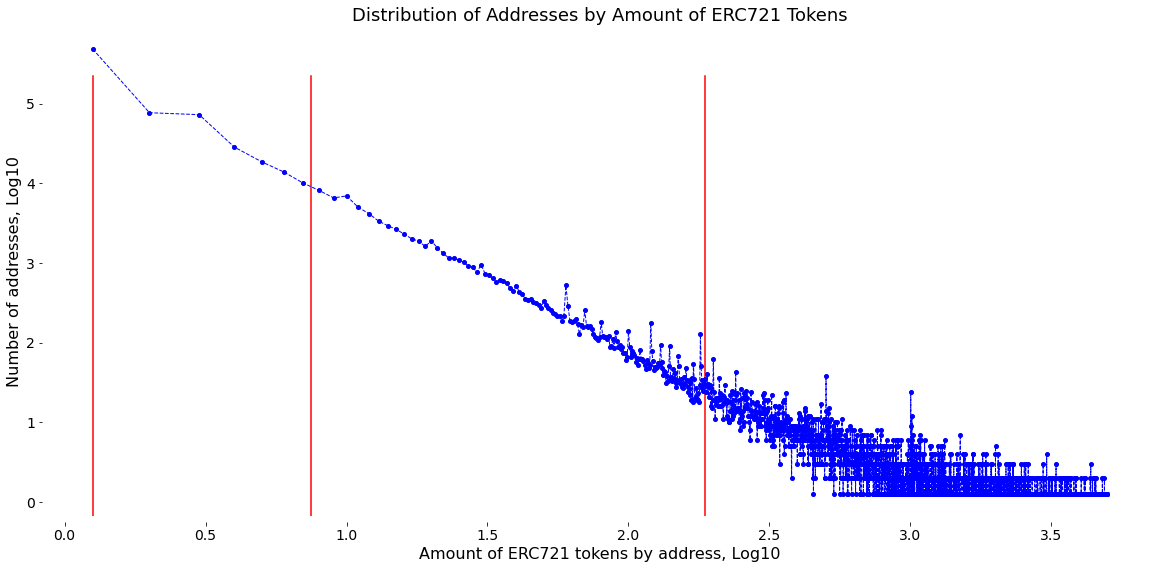

In [9]:
amount_of_erc721_tokens_boundary_levels = \
    grade_boundaries_analysis(
        distribution_df=address_agg_by_sum_amount_of_tokens_df,
        value_column = 'sum_amount',
        value_chart_label = 'Amount of ERC721 tokens by address, Log10',
        value_name = 'Amount of ERC721 tokens',
        chart_title = 'Distribution of Addresses by Amount of ERC721 Tokens',
        max_show_value = 5000)

### Analysis of Grade Boundaries. Fee spending to contracts
Described in the [Extraordinary Hackers and Masters of the Great Web. Gas Analysis](extraordinary_hackers_and_masters__gas_analysis.ipynb) Jupyter notebook